## 1. Importing Libraries

In [33]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 2. Loading the data

In [2]:
# Load the data
train = pd.read_csv("../data/Housing_dataset_train.csv")
test = pd.read_csv("../data/Housing_dataset_test.csv")
submission = pd.read_csv("../data/Sample_submission.csv")

In [3]:
train.head(3)

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.00000,2.00000,1.00000,1149999.56500
1,2748,Ondo,Apartment,NaN,2.00000,4.00000,1672416.68900
2,9261,Ekiti,NaN,7.00000,5.00000,NaN,3364799.81400


In [4]:
test.head(2)

,ID,loc,title,bedroom,bathroom,parking_space
0,845,Kano,Penthouse,4,1,2
1,1924,Adamawa,Apartment,2,2,4


In [5]:
submission.head(2)

,ID
0,845
1,1924


In [6]:
print(f"The train dataset contains {train.shape[0]} rows and {train.shape[1]} columns")

The train dataset contains 14000 rows and 7 columns


In [7]:
print(f"The test dataset contains {test.shape[0]} rows and {test.shape[1]} columns")

The test dataset contains 6000 rows and 6 columns


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


In [9]:
train.describe(include='all')

,ID,loc,title,bedroom,bathroom,parking_space,price
count,14000.00000,12187,12278,12201.00000,12195.00000,12189.00000,14000.00000
unique,NaN,36,10,NaN,NaN,NaN,NaN
top,NaN,Kaduna,Flat,NaN,NaN,NaN,NaN
freq,NaN,370,1372,NaN,NaN,NaN,NaN
mean,4862.70036,NaN,NaN,4.30817,3.13424,3.16983,2138081.74874
std,3818.34821,NaN,NaN,2.44116,2.03595,1.59941,1083056.66489
min,0.00000,NaN,NaN,1.00000,1.00000,1.00000,431967.29000
25%,1672.75000,NaN,NaN,2.00000,1.00000,2.00000,1393989.51750
50%,3527.00000,NaN,NaN,4.00000,2.00000,3.00000,1895223.07050
75%,8011.25000,NaN,NaN,6.00000,5.00000,4.00000,2586699.49400


### Handling missing values and Duplicates

In [10]:
# check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(True, False)

In [11]:
# check for duplicate values
train.duplicated().sum().any(), test.duplicated().sum().any() 

(False, False)

In [12]:
train.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [13]:
train['bedroom'].fillna(train['bedroom'].mean(), inplace=True)
train['bathroom'].fillna(train['bathroom'].mean(), inplace=True)
train['parking_space'].fillna(0, inplace=True) # assuming the missing values mean no parking space

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999
 - Fill with zero

In [14]:
train['title'].value_counts()

Flat                    1372
Apartment               1331
Townhouse               1327
Mansion                 1322
Detached duplex         1312
Penthouse               1306
Semi-detached duplex    1299
Bungalow                1293
Terrace duplex          1266
Cottage                  450
Name: title, dtype: int64

In [15]:
train[train['title'].isnull()==True]

,ID,loc,title,bedroom,bathroom,parking_space,price
2,9261,Ekiti,NaN,7.00000,5.00000,0.00000,3364799.81400
12,3753,NaN,NaN,5.00000,3.13424,5.00000,2087592.81200
16,488,Ondo,NaN,4.00000,2.00000,2.00000,1851837.90200
19,3389,Kaduna,NaN,5.00000,1.00000,1.00000,1424308.19900
27,1288,Delta,NaN,1.00000,2.00000,2.00000,1412019.59000
...,...,...,...,...,...,...,...
13986,3433,Taraba,NaN,2.00000,1.00000,4.00000,1062526.20800
13988,11693,Abia,NaN,3.00000,2.00000,3.00000,1714768.80200
13991,8857,Zamfara,NaN,4.00000,7.00000,0.00000,1601556.46900
13993,3731,Delta,NaN,4.30817,1.00000,3.00000,2458443.81800


In [16]:
train_clean = train.dropna()

Missing categorica values can also be filled with their modes

*Mode imputation for 'title' and 'loc' columns*

mode_title = train['title'].mode()[0]

mode_loc = train['loc'].mode()[0]

train['title'].fillna(mode_title, inplace=True)
train['loc'].fillna(mode_loc, inplace=True)

In [17]:
train_clean.shape

(10531, 7)

## EDA - Correlation

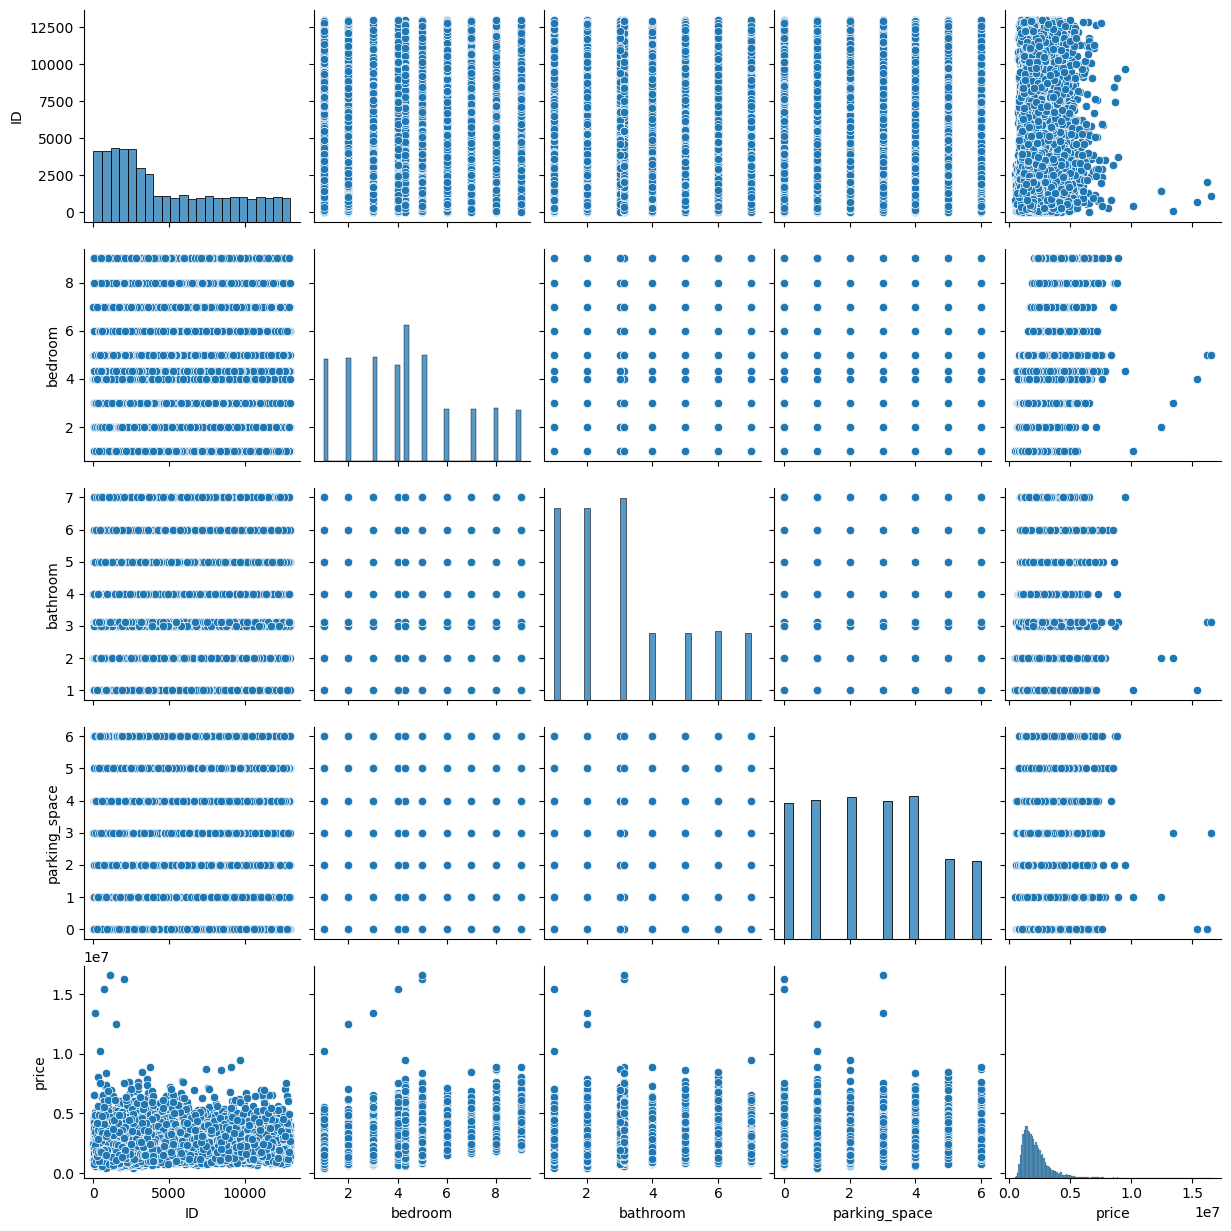

In [18]:
# Use pair plot to get a general overview of the correlation between the feature columns
sns.pairplot(train_clean)

In [19]:
ordered_categories = [
    'Flat', 'Apartment', 'Townhouse', 'Terrace duplex', 
    'Semi-detached duplex', 'Detached duplex', 'Bungalow', 
    'Penthouse', 'Mansion', 'Cottage'
]

train_clean['title'] = pd.Categorical(train_clean['title'], categories=ordered_categories, ordered=True)
test['title'] = pd.Categorical(test['title'], categories=ordered_categories, ordered=True)

print(train_clean['title'].dtype)
print(test['title'].dtype)

category
category


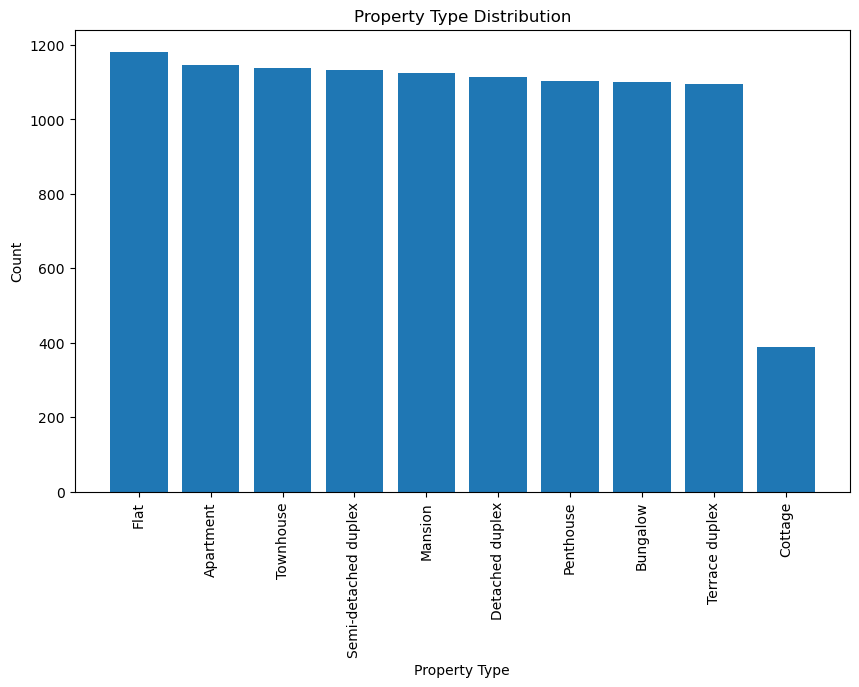

In [20]:
# Create a bar chart to visualize the distribution of different property types
plt.figure(figsize=(10, 6))
property_type_counts = train_clean['title'].value_counts()
plt.bar(property_type_counts.index, property_type_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.title('Property Type Distribution')
plt.show()

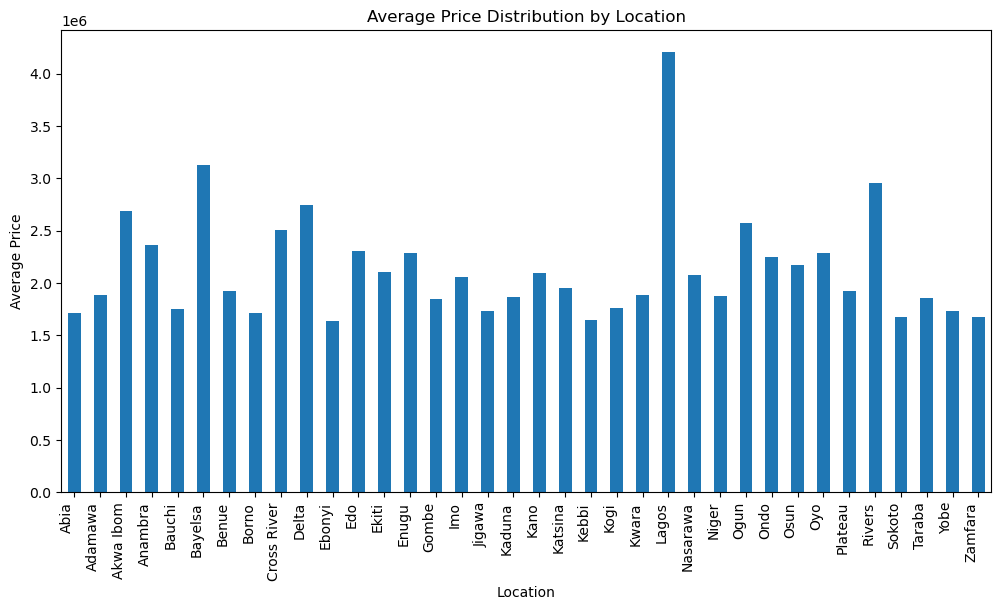

In [21]:
# Grouping the data by location and calculating the mean price for each location
price_by_location = train_clean.groupby('loc')['price'].mean()

# Plotting the bar chart for price distribution by location
plt.figure(figsize=(12, 6))
price_by_location.plot(kind='bar')
plt.xticks(rotation=90, ha='right')
plt.xlabel('Location')
plt.ylabel('Average Price')
plt.title('Average Price Distribution by Location')
plt.show()

## Data Preprocessing

In [22]:
# Create a LabelEncoder instance
le = LabelEncoder()

# covert the title column to numeric data for the train and test set
train_clean['title_encoded'] = le.fit_transform(train_clean['title'])
test['title_encoded'] = le.fit_transform(test['title'])

# perform one-hot encoding for the 'loc' column
loc_encoded_train = pd.get_dummies(train_clean['loc'], prefix='loc')
loc_encoded_test = pd.get_dummies(test['loc'], prefix='loc')

# concatenate the one-hot encoded columns with the original DataFrame
train_clean = pd.concat([train_clean, loc_encoded_train], axis=1)
test = pd.concat([test, loc_encoded_test], axis=1)

# Drop the original 'title' and 'loc' columns
train_clean.drop(['title', 'loc', 'ID'], axis=1, inplace=True)
test.drop(['title', 'loc', 'ID'], axis=1, inplace=True)

train_clean.shape, test.shape

((10531, 41), (6000, 40))

In [23]:
train_clean.head(2)

,bedroom,bathroom,parking_space,price,title_encoded,loc_Abia,loc_Adamawa,loc_Akwa Ibom,loc_Anambra,loc_Bauchi,...,loc_Ogun,loc_Ondo,loc_Osun,loc_Oyo,loc_Plateau,loc_Rivers,loc_Sokoto,loc_Taraba,loc_Yobe,loc_Zamfara
0,2.00000,2.00000,1.00000,1149999.56500,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.30817,2.00000,4.00000,1672416.68900,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Feature Engineering

In [24]:
# Feature Engineeering can be particular to individual creativity

## Modelling

In [25]:
X = train_clean.drop('price', axis=1)
y = train_clean.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Instantiate the model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Make predictions
y_pred = reg_model.predict(X_test)

# Check the MAE score of the model
print(f'LinearRegression MAE score on the X_test is: {mean_absolute_error(y_test, y_pred)}')

LinearRegression MAE score on the X_test is: 490758.1956950683


In [34]:
# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Check the MAE score of the model
print(f'Root Mean Squared Error (RMSE) score: {rmse:.2f}')

Root Mean Squared Error (RMSE) score: 738190.48


<a name="Predictions"></a>
## Making predictions of the test set and creating a submission file

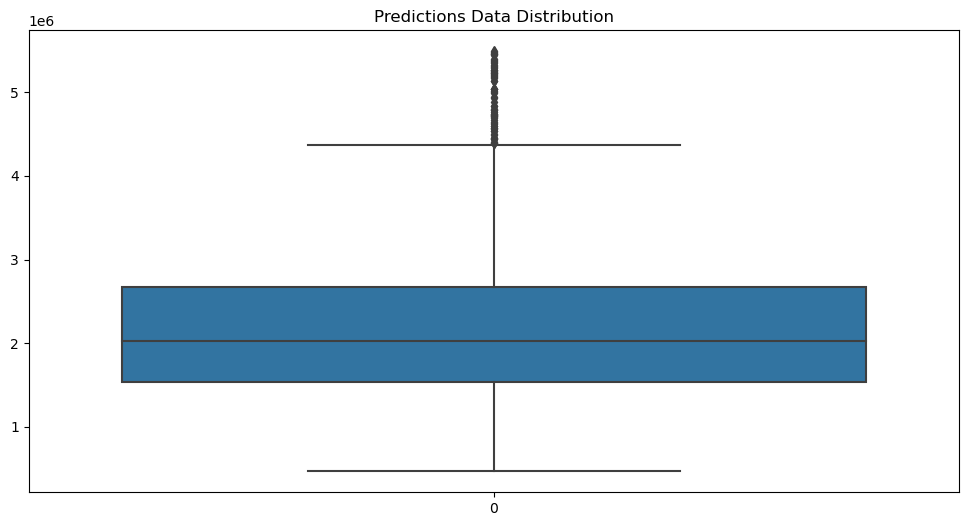

In [30]:
# Make prediction on the test set
predictions = reg_model.predict(test)

# # Create a submission file
sub_file = submission.copy()
sub_file['price'] = predictions

# Check the distribution of your predictions
plt.figure(figsize=(12, 6))
sns.boxplot(sub_file.price)
plt.title('Predictions Data Distribution');

 - There are some outliers in our predictions. 
 - More inspection/data preprocessing is needed

In [31]:
sub_file.head()

,ID,price
0,845,1942844.89890
1,1924,1117683.66480
2,10718,1450661.00524
3,12076,5450909.37216
4,12254,2309477.24141


In [32]:
# Write to csv file to submit to Zindi
sub_file.to_csv("Baseline.csv", index = False)